# 3D Cervical Vertebrae Segmentation (RSNA 2022) with MONAI - Resume Training

In [1]:
# Install packages
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
! pip install pyjpegls
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.5 MB/s eta 0:00:00


In [2]:
# Import libraries
import os
import warnings
from glob import glob
import time
import random
import string
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi

# DICOM image files (.dcm)
import pydicom
from pydicom import dcmread

# NIfTI image files (.nii)
import nibabel as nib

# Required dependencies
import gdcm
import pylibjpeg

# Pytorch
import torch
import torch.nn as nn
from torch.nn.functional import one_hot

# Monai
import monai
from monai.data import ArrayDataset, DataLoader, decollate_batch
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    Resize,
    ScaleIntensity,
    RandFlip,
    RandAffine,
    RandGridDistortion
)
from monai.utils import set_determinism, first

# Sklearn
from sklearn.model_selection import KFold

2024-09-05 05:52:39.777644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 05:52:39.777795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 05:52:39.915529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Resuming Configuration

In [3]:
# Path 
base_path = "../input/rsna-2022-cervical-spine-fracture-detection"
TRAIN_IMAGES_PATH = f'{base_path}/train_images'
SEGMENTATIONS_PATH = f'{base_path}/segmentations'
OUTPUT_DIR = '.'


last_model_output = 'CT7359RN_last_model' # INSERT MODEL ID
last_config_pkl = 'CT7359RN_config.pkl' # INSERT MODEL ID
MODEL_PATH = f'/kaggle/input/ct7359rn-400-480-epochs/{last_model_output}' # INSERT DATASET
CONFIG_PATH = f'/kaggle/input/ct7359rn-400-480-epochs/{last_config_pkl}' # INSERT DATASET

# Load config from the pkl file
with open(CONFIG_PATH, 'rb') as f:
    config = pickle.load(f)

for k, v in config.items(): print(f'{k}: {v}')

ID: CT7359RN
spatial_size: (128, 128, 128)
prob: 0.5
k: 5
batch_size: 4
epochs: 480
lr: 0.0001
loss_weights: (0.0, 1.0)
channels: (16, 32, 64, 128, 256)
strides: (2, 2, 2, 2)
kernel_size: 3
up_kernel_size: 3
num_res_units: 2
act: PRELU
dropout: 0.0
bias: True
val_fold_idx: 1


In [4]:
# Get output and config path file
OUTPUT_FILE = OUTPUT_DIR + f'/{config["ID"]}_train_val_losses.csv'                   
CONFIG_FILE = OUTPUT_DIR + f'/{config["ID"]}_config.pkl'

# New max number of epochs
config['epochs'] = 560 # INSERT MAX EPOCHS

In [5]:
# Save config to pickle file
with open(CONFIG_FILE, 'wb') as f:
    pickle.dump(config, f)

In [6]:
# Set deterministic training for reproducibility
set_determinism(seed=0)

In [7]:
# Enabling GPU
# https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Enable cuDNN benchmark. Set to True whenever the input model does not change over training, False if, eg, some layers are deactivated
torch.backends.cudnn.benchmark = True

GPU: Tesla T4 is available.
cuda


In [8]:
# Masks to be reverted 
revert_mask = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
    ]

## Functions

In [9]:
def read_dicom_scan(folder_path):
    """ Read CT scan (dicom files) and stack the slices"""
    slices = []
    for filename in sorted(os.listdir(folder_path), key=lambda x: int(x.split(".")[0])):
        if filename.endswith('.dcm'):
            filepath = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(filepath)
            slices.append(ds.pixel_array)
    scan = np.stack(slices, -1).astype('float64')
    return scan


def read_nifti_file(file_path, revert_mask=revert_mask):
    """ Read nifit file segmentation"""    
    data = nib.load(file_path).get_fdata()
    shape = data.shape
    # Reorient because segmentations are done over the sagittal plane
    data = data.transpose(1, 0, 2)[::-1, :, ::-1]
    # Revert the files that have inverted sequence (from bottom to top)
    if file_path in revert_mask:
        data[:, :, ::-1]
    return data


def zoom_volume(vol, spatial_size):
    """Resize across z-axis"""
    """ NON UTILIZZATA SOSTITUITA DA RESIZE"""
    # Set the desired depth
    desired_width, desired_height, desired_depth = spatial_size
    # Get current depth
    current_depth = vol.shape[-1]
    current_width = vol.shape[0]
    current_height = vol.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    #vol = ndi.zoom(vol, (width_factor, height_factor, depth_factor), order=0, mode='constant')
    zoom_transform = Zoom(zoom=(width_factor, height_factor, depth_factor), keep_size=False)
    zoom_vol = zoom_transform(vol)
    return zoom_vol

def one_hot_encoding_multiclass_mask(mask):
    """ Binary OneHot Encoding of Multi-class masks"""
    labels = list(range(8))
    num_labels = len(labels)
    c, h, w, d = mask.shape
    enc_mask = np.zeros((num_labels, h, w, d))
    for c in range(1, num_labels):  # this loop starts from label 1 to ignore background 0
        enc_mask[c, :, :, :] = (mask == labels[c]) # 1 for the pixel belonging to that class, 0 for the rest of the pixel
        
    return enc_mask

def expand_dims(arr):
    return np.expand_dims(arr, axis=0)

def training_plot(file, output_path, config):
    train_bce_dl_loss = file['Train_bce_dl_loss']
    val_bce_dl_loss = file['Val_bce_dl_loss']
    epochs = range(1, len(train_bce_dl_loss) + 1)
    plt.plot(epochs, train_bce_dl_loss, label='Training BCE-DiceLoss', color='darkblue')
    plt.plot(epochs, val_bce_dl_loss, label='Val BCE-DiceLoss', color='darkorange')
    plt.title('Training & Val Losses')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Training_Losses_plot.png'))
    plt.show()
    
def validation_metric_plot(file, output_path, config):
    val_metric = file['Val_metric']
    epochs = range(1, len(val_metric)+1)
    plt.plot(epochs, val_metric, label='Validation DiceMetric', color='red')
    plt.title('Validation Metric')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid(False)
    plt.savefig(os.path.join(output_path, f'{config["ID"]}_Validation_Metric_plot.png'))
    plt.show()

## Data Loading

In [10]:
# Create Dataset
df = pd.DataFrame()

# Store all the nifti files in the segmentation folder
df['ID'] = os.listdir(SEGMENTATIONS_PATH)

# Remove the extension '.nii'
df['ID'] = df['ID'].apply(lambda x: x[:-4])

# Add complete path to reach segmentation file (nifti)
df['label_path'] = df['ID'].apply(lambda x: os.path.join(SEGMENTATIONS_PATH, x + '.nii'))

# Add complete path to reach CT scan folder in train_images
df['image_path'] = df['ID'].apply(lambda x: os.path.join(TRAIN_IMAGES_PATH, x))

# Initialize KFold
kf = KFold(n_splits=config['k'], shuffle=True, random_state=42)

# Create a new column for fold indices
df['fold'] = -1

# Assign fold indices
for fold, (train_index, val_index) in enumerate(kf.split(df)):
    df.loc[val_index, 'fold'] = fold

# Print the shape of the dataset
print(df.shape)

# Show the head
df.head()

(87, 4)


,ID,label_path,image_path,fold
0,1.2.826.0.1.3680043.780,../input/rsna-2022-cervical-spine-fracture-det...,../input/rsna-2022-cervical-spine-fracture-det...,0
1,1.2.826.0.1.3680043.21321,../input/rsna-2022-cervical-spine-fracture-det...,../input/rsna-2022-cervical-spine-fracture-det...,4
2,1.2.826.0.1.3680043.6125,../input/rsna-2022-cervical-spine-fracture-det...,../input/rsna-2022-cervical-spine-fracture-det...,4
3,1.2.826.0.1.3680043.30067,../input/rsna-2022-cervical-spine-fracture-det...,../input/rsna-2022-cervical-spine-fracture-det...,2
4,1.2.826.0.1.3680043.12833,../input/rsna-2022-cervical-spine-fracture-det...,../input/rsna-2022-cervical-spine-fracture-det...,0


In [11]:
# Define training and validation dataset

val_fold_idx = config['val_fold_idx']

df_train = df[df.fold != val_fold_idx].reset_index()
print(df_train.shape)

df_val = df[df.fold == val_fold_idx].reset_index()
print(df_val.shape)

(69, 5)
(18, 5)


## Transforms

In [12]:
# Define training transforms for image and label
train_image_trans = Compose(
    [   
        # Load Data
        read_dicom_scan,
        # Data Preparation
        expand_dims, 
        Resize(spatial_size=config['spatial_size'], mode="area"), # Resize the volume to target spatial_size
        ScaleIntensity(), # scale between (0,1)
        # Data Augmentation 
        RandFlip(prob=config['prob'], spatial_axis=0), # width
        RandFlip(prob=config['prob'], spatial_axis=1), # height
        RandGridDistortion(num_cells=5, distort_limit=(-0.03, 0.03), prob=config['prob']),
        RandAffine(prob=config['prob'], 
                   translate_range=[int(x*y) for x, y in zip(config['spatial_size'], [0.3, 0.3, 0.3])], padding_mode='zeros')
    ]
)
train_label_trans = Compose(
    [   
        # Load data
        read_nifti_file,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"),
        one_hot_encoding_multiclass_mask, 
        # Data Augmentation
        RandFlip(prob=config['prob'], spatial_axis=0), # width
        RandFlip(prob=config['prob'], spatial_axis=1), # height
        RandGridDistortion(num_cells=5, distort_limit=(-0.03, 0.03), prob=config['prob']),
        RandAffine(prob=config['prob'], 
                   translate_range=[int(x*y) for x, y in zip(config['spatial_size'], [0.3, 0.3, 0.3])], padding_mode='zeros')
    ]
)

# Define validation transforms for image and label (no augmentation)
val_image_trans = Compose(
    [
        # Load data
        read_dicom_scan,
        # Data Preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"), 
        ScaleIntensity()
    ]
)
val_label_trans = Compose(
    [
        # Load data
        read_nifti_file,
        # Data preparation
        expand_dims,
        Resize(spatial_size=config['spatial_size'], mode="area"),
        one_hot_encoding_multiclass_mask
    ]
)

In [13]:
# Define train dataset and dataloader
train_ds = ArrayDataset(df_train.image_path, train_image_trans, df_train.label_path, train_label_trans)
train_loader = DataLoader(train_ds, batch_size=config['batch_size'], num_workers=2)

# Define validation dataset and dataloader
val_ds = ArrayDataset(df_val.image_path, val_image_trans, df_val.label_path, val_label_trans)
val_loader = DataLoader(val_ds, batch_size=config['batch_size'], num_workers=2)

In [14]:
# Take the first processed train batch and print the shape
first_train_image, first_train_label = first(train_loader)
print(first_train_image.shape, first_train_label.shape)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([4, 1, 128, 128, 128]) torch.Size([4, 8, 128, 128, 128])


## Resuming Model, Loss & Optimizer

In [15]:
# Define the 3D Unet model
unet_model = UNet(
    spatial_dims = 3, # (Height, Width, Depth)
    in_channels = 1,
    out_channels = 8, # 8 Binary mask 7 as the vertebrae(C1->C7) + background
    channels = config['channels'], # Channels per layer
    strides = config['strides'], # Stride per layers
    kernel_size = config['kernel_size'], # Size of the kernel for each layer
    up_kernel_size = config['up_kernel_size'], # Upsampling convolution kernel size
    num_res_units = config['num_res_units'], # Number of residual units
    act = config['act'], # Activation function
    dropout = config['dropout'], # Dropout rate
    bias = config['bias'] # Presence of bias term in convolution blocks
)
unet_model = unet_model.to(DEVICE)

In [16]:
# Define Loss function

# DiceLoss function
#loss_function = DiceLoss(
#    include_background = True,  # If False, channel index 0 (background) is excluded from the calculation
#    squared_pred = False, # Use squared versions of targets and predictions in the denominator or not
#    reduction = 'mean' # Reduction to apply to the output
#)

# BCE-DiceLoss function
# Define DiceLoss (MONAI)
dice_loss_fn = DiceLoss(
    include_background=True,  # Include background class in the Dice computation
    to_onehot_y=False,  # Assuming the labels are not one-hot encoded
    sigmoid=False,  # Apply sigmoid to the input tensor
    softmax=True,  # Do not apply softmax to the input tensor
    squared_pred=True,  # Do not use squared predictions
    reduction='mean', # Reduction to apply to the output
    smooth_nr=1.0, # constant added to the numerator to avoid zero
    smooth_dr=1.0 # constant added to the denominator to avoid nan
)
# Define BCEWithLogitsLoss (PyTorch)
bce_loss_fn = nn.BCEWithLogitsLoss()
# Combine BCE and Dice losses
def bce_diceloss(input, target, loss_weights=config['loss_weights']):    # Compute the BCE loss
    bce_loss = loss_weights[0] * bce_loss_fn(input, target)
    # Compute the Dice loss
    dice_loss = loss_weights[1] * dice_loss_fn(input, target)
    # Combine the losses
    total_loss = (bce_loss + dice_loss) / sum(loss_weights)
    return total_loss
# Set the combined loss function
criterion = bce_diceloss

In [17]:
# Define metric

dice_metric = DiceMetric(include_background=True, reduction="mean")

In [18]:
# Define Optimizer

# Adam optimzier
#optimizer = torch.optim.Adam(
#    unet_model.parameters(), # Model's params
#    lr = 1e-3 # Learning rate
#)

# AdamW optimizer
optimizer = torch.optim.AdamW(
    unet_model.parameters(), 
    lr = config['lr'] # weight_decay = config['weight_decay'] 
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

In [19]:
# Use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()

# Define the transforms to apply to model prediction 
post_trans = Compose([Activations(sigmoid=False, softmax=True, dim=0), AsDiscrete(threshold=0.5)])

## Resuming Training Loop

In [20]:
# Resume State from checkpoint
checkpoint = torch.load(MODEL_PATH)

# Resume model, optimizer, learning rate scheduler, loss and last epoch 
unet_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
#loss = checkpoint['avg_train_bce_dl_loss']
start_epoch = checkpoint['epoch']+1

In [21]:
def resuming_train_loop(model,
                        train_loader,
                        val_loader,
                        diceloss_function,
                        bce_function,
                        bce_diceloss_function,
                        metric,
                        optimizer,
                        lr_scheduler,
                        start_epoch,
                        config,
                        output_dir,
                        output_file,
                        device):
    
    # Container to store train losses values per epoch
    train_dl_values = []
    train_bce_values = []
    train_bce_dl_values = []
    
    # Container to store val losses values per epoch
    val_dl_values = []
    val_bce_values = []
    val_bce_dl_values = []

    # Container to store val metric values per epoch
    val_metric_values = []

    # Store best val metric
    best_val_metric = -1

    total_start = time.time()
    # Iterate over the epochs
    for epoch in range(start_epoch, config['epochs']+1):
        epoch_start = time.time()
        print("-" * 10)
        print(f"EPOCH {start_epoch}/{config['epochs']}")
        model.train() # Set the model in training mode
        epoch_train_dl_loss, epoch_train_bce_loss, epoch_train_bce_dl_loss = 0, 0, 0
        epoch_val_dl_loss, epoch_val_bce_loss, epoch_val_bce_dl_loss = 0, 0, 0
        # Iterate over the batches
        for step, batch_data in enumerate(train_loader):
            step_start = time.time()
            inputs, labels = batch_data
            inputs, labels = (inputs.to(device), labels.to(device))
            optimizer.zero_grad() # Clear the old gradients before computing new ones
            # Enable automatic mixed precision (amp)
            with torch.cuda.amp.autocast():
                outputs = model(inputs) # Make predictions for current batch
                train_dl_loss = diceloss_function(outputs, labels) # Compute DiceLoss (train)
                train_bce_loss = bce_function(outputs, labels) # Compute BCE loss (train)
                train_bce_dl_loss = bce_diceloss_function(outputs, labels) # Compute BCE-DiceLoss (train)
            scaler.scale(train_bce_dl_loss).backward() # Compute the gradients
            scaler.step(optimizer) # Update model weights
            scaler.update()
            epoch_train_dl_loss += train_dl_loss.item()
            epoch_train_bce_loss += train_bce_loss.item()
            epoch_train_bce_dl_loss += train_bce_dl_loss.item()
            # REPORT PER BATCH 
            print(
                f"batch: {step}/{len(train_ds) // train_loader.batch_size}"
                f", train_dl_loss: {train_dl_loss.item():.4f}"
                f", train_bce_loss: {train_bce_loss.item():.4f}"
                f", train_bce_dl_loss: {train_bce_dl_loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )
        lr_scheduler.step()
        # Compute mean losses over the batches
        avg_train_dl_loss = epoch_train_dl_loss / (step+1)
        avg_train_bce_loss = epoch_train_bce_loss / (step+1)
        avg_train_bce_dl_loss = epoch_train_bce_dl_loss / (step+1)

        # EVALUATE MODEL ON VALIDATION SET
        model.eval() # Set the model to evaluation mode
        with torch.no_grad(): # Disable gradient computation and reduce memory consumption
            for step, val_data in enumerate(val_loader):
                val_inputs, val_labels = val_data
                val_inputs, val_labels = (val_inputs.to(device), val_labels.to(device))
                val_outputs = model(val_inputs)
                # Compute losses
                val_dl_loss = diceloss_function(val_outputs, val_labels) # Compute DiceLoss (val)
                val_bce_loss = bce_function(val_outputs, val_labels) # Compute BCE (val)
                val_bce_dl_loss = bce_diceloss_function(val_outputs, val_labels) # Compute BCE-DiceLoss (val)
                # Apply post transforms
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # Compute metric
                metric(y_pred=val_outputs, y=val_labels)
                
                epoch_val_dl_loss += val_dl_loss.item()
                epoch_val_bce_loss += val_bce_loss.item()
                epoch_val_bce_dl_loss += val_bce_dl_loss.item()
                
            # Aggregate the final mean dice result
            avg_val_metric = metric.aggregate().item()
            
        # Compute mean val losses over the batches
        avg_val_dl_loss = epoch_val_dl_loss / (step + 1)
        avg_val_bce_loss = epoch_val_bce_loss / (step + 1)
        avg_val_bce_dl_loss = epoch_val_bce_dl_loss / (step + 1)

        # REPORT PER EPOCH
        print(f'LOSS train DiceLoss: {avg_train_dl_loss:.4f}, LOSS train BCE: {avg_train_bce_loss:.4f}, LOSS train BCE-DiceLoss: {avg_train_bce_dl_loss:.4f}, LOSS val DiceLoss: {avg_val_dl_loss:.4f}, LOSS val BCE: {avg_val_bce_loss:.4f}, LOSS val BCE-DiceLoss: {avg_val_bce_dl_loss:.4f}, METRIC val: {avg_val_metric:.4f}')

        # Store train/val losses and val metric per epoch
        train_dl_values.append(avg_train_dl_loss)
        train_bce_values.append(avg_train_bce_loss)
        train_bce_dl_values.append(avg_train_bce_dl_loss)
        val_dl_values.append(avg_val_dl_loss)
        val_bce_values.append(avg_val_bce_loss)
        val_bce_dl_values.append(avg_val_bce_dl_loss)
        val_metric_values.append(avg_val_metric)
        
        # Reset the metric status
        metric.reset()

        # Log the running loss averaged per batch for train and the running metric averaged per batch for val
        with open(output_file, "a") as file:
            file.write(f"{epoch}, {avg_train_dl_loss}, {avg_train_bce_loss}, {avg_train_bce_dl_loss}, {avg_val_dl_loss}, {avg_val_bce_loss}, {avg_val_bce_dl_loss}, {avg_val_metric}\n")
        
        # Track best performance, and save the model's state
        if avg_val_metric > best_val_metric:
            best_val_metric = avg_val_metric
            best_model = {'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                          'train DiceLoss loss': avg_train_dl_loss,
                          'train BCE loss': avg_train_bce_loss,
                          'train BCE-DiceLoss loss': avg_train_bce_dl_loss,
                          'val DiceLoss loss': avg_val_dl_loss,
                          'val BCE loss': avg_val_bce_loss,
                          'val BCE-DiceLoss loss': avg_val_bce_dl_loss
                         }
        print(f"time consuming of epoch {epoch} is: {(time.time() - epoch_start):.4f}")
        
        # Save last model's state
        if epoch == config['epochs']:
            last_model = {'epoch': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                          'train DiceLoss loss': avg_train_dl_loss,
                          'train BCE loss': avg_train_bce_loss,
                          'train BCE-DiceLoss loss': avg_train_bce_dl_loss,
                          'val DiceLoss loss': avg_val_dl_loss,
                          'val BCE loss': avg_val_bce_loss,
                          'val BCE-DiceLoss loss': avg_val_bce_dl_loss
                          }
            
    total_time = time.time() - total_start

    # Save Train Losses and Val Metric
    with open(OUTPUT_FILE, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Train_dl_loss', 'Train_bce_loss', 'Train_bce_dl_loss', 'Val_dl_loss', 'Val_bce_loss', 'Val_bce_dl_loss', 'Val_metric'])
        csvwriter.writerows(zip(train_dl_values, train_bce_values, train_bce_dl_values, val_dl_values, val_bce_values, val_bce_dl_values, val_metric_values))    
        
    # Save Best Model's State
    best_model_path = os.path.join(OUTPUT_DIR, f"{config['ID']}_best_model")
    torch.save(best_model, best_model_path)

    # Save Last Model's State
    last_model_path = os.path.join(OUTPUT_DIR, f"{config['ID']}_last_model")
    torch.save(last_model, last_model_path)

In [22]:
# Resuming training loop
resuming_train_loop(model=unet_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    diceloss_function=dice_loss_fn,
                    bce_function=bce_loss_fn,
                    bce_diceloss_function=criterion,
                    metric=dice_metric,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    start_epoch=start_epoch,
                    config=config,
                    output_dir=OUTPUT_DIR,
                    output_file=OUTPUT_FILE,
                    device=DEVICE)

----------
EPOCH 481/560
batch: 0/17, train_dl_loss: 0.3651, train_bce_loss: 1.7441, train_bce_dl_loss: 0.3651, step time: 5.3051
batch: 1/17, train_dl_loss: 0.3568, train_bce_loss: 1.7667, train_bce_dl_loss: 0.3568, step time: 0.3877
batch: 2/17, train_dl_loss: 0.3970, train_bce_loss: 1.7513, train_bce_dl_loss: 0.3970, step time: 0.4308
batch: 3/17, train_dl_loss: 0.5065, train_bce_loss: 1.7585, train_bce_dl_loss: 0.5065, step time: 0.3691
batch: 4/17, train_dl_loss: 0.3676, train_bce_loss: 1.7580, train_bce_dl_loss: 0.3676, step time: 0.4146
batch: 5/17, train_dl_loss: 0.3591, train_bce_loss: 1.7710, train_bce_dl_loss: 0.3591, step time: 0.3629
batch: 6/17, train_dl_loss: 0.4088, train_bce_loss: 1.7533, train_bce_dl_loss: 0.4088, step time: 0.4070
batch: 7/17, train_dl_loss: 0.3572, train_bce_loss: 1.7447, train_bce_dl_loss: 0.3572, step time: 0.3713
batch: 8/17, train_dl_loss: 0.3690, train_bce_loss: 1.7606, train_bce_dl_loss: 0.3690, step time: 0.4239
batch: 9/17, train_dl_loss: 0.

## Plot Training/Validation Losses & Validation Metric

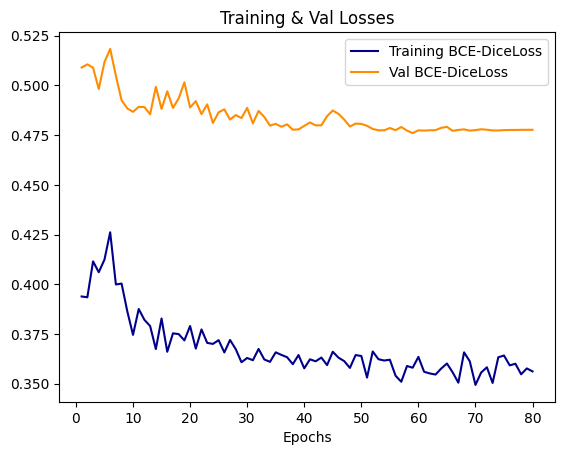

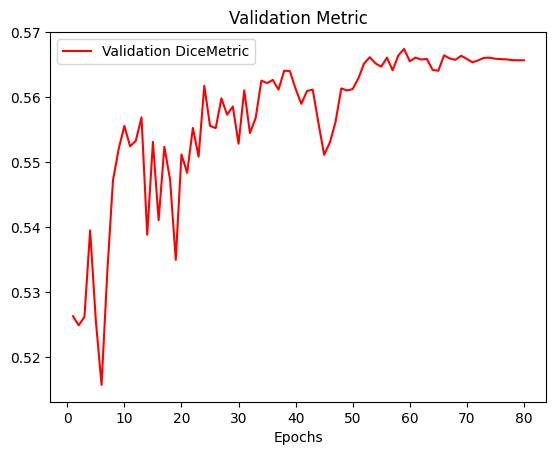

In [23]:
# Load txt file
path = f"/kaggle/working/{config['ID']}_train_val_losses.csv"
train_val_losses = pd.read_csv(path)

# Plot and Save Train & Val Losses as png in output dir
training_plot(train_val_losses, OUTPUT_DIR, config)

# Plot and Save Val Metric as png in output dir
validation_metric_plot(train_val_losses, OUTPUT_DIR, config)